# Digit Recognizer Competitions

The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

## Install & Import Required Dependencies


*   **PyTorch**: For tensor operations and neural network functionalities, also it's include **Torchvision** for image processing, including dataset handling and transformations.
*   **Pandas**: For data manipulation and saving results to CSV.
*   **Matplotlib**: For visualizing images and results.



In [ ]:
!pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

## Load & Prepare The Dataset

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.


- **Data Transformation:**
  1. Applies a series of image transformations.
  2. Converts images to PyTorch tensors.
  3. Normalizes the tensor images to have mean 0.5 and standard deviation 0.5.

- **Training Data:**
  1. Loads the MNIST training dataset with the specified transformations.
  2. Creates a DataLoader for batching and shuffling the training data.

- **Testing Data:**
  1. Loads the MNIST test dataset with the specified transformations.
  2. Creates a DataLoader for batching the test data without shuffling.


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train = MNIST(root="/data", train=True, download=True, transform=transform)

train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True)


test = MNIST(root="/data", train=False, transform=transform)

test_loader = DataLoader(dataset=test, batch_size=32, shuffle=False)

## Define the Neural Network Model & Sets Up The Device


- **Define a feedforward neural network with two fully connected layers**:
    - First layer: 784 input features (28x28 images) to 128 hidden units.
    - Second layer: 128 hidden units to 10 output classes (digits 0-9).
    - Activation Function: `ReLU` is used after the first layer.

- **Device Setup**:
  - Determines if a GPU is available and sets the device accordingly (GPU if available, otherwise CPU).
  - Moves the model to the specified device for training or inference.



In [3]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)

        return self.fc2(self.act(self.fc1(x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitRecognizer().to(device)

## Loss Function & Optimizer


- **Cross Entropy Loss**: A loss function that measures the classification error between predictions and actual labels.

- **Adam Optimizer**: Updates/Adjustes model parameters to minimize the loss with adaptive learning rates.


In [4]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train The Model

- **Epochs**: Number of iterations over the entire training dataset.

- **Training Process**:
  - The model is set to training mode using `model.train()`.
  - For each batch, compute the loss using `loss_function`.
  - Perform backpropagation and update model parameters with `optimizer.step()`.
  - Compute training accuracy by comparing predicted labels with actual labels.

- **Output**:
  - Epoch: The number of the current epoch.
  - Loss: Average loss for the current epoch.
  - Accuracy: Training accuracy as a percentage.


In [5]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_train += labels.size(0)

        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy(Train): {train_accuracy}%")

Epoch 1, Loss: 0.35279504987398785, Accuracy(Train): 89.64333333333333%
Epoch 2, Loss: 0.17903282189369202, Accuracy(Train): 94.64833333333333%
Epoch 3, Loss: 0.13234237704624732, Accuracy(Train): 95.895%
Epoch 4, Loss: 0.10982743563031157, Accuracy(Train): 96.595%
Epoch 5, Loss: 0.09569725017026066, Accuracy(Train): 97.00833333333334%
Epoch 6, Loss: 0.08508547075620541, Accuracy(Train): 97.30833333333334%
Epoch 7, Loss: 0.07740264667390535, Accuracy(Train): 97.52333333333333%
Epoch 8, Loss: 0.06942448264529619, Accuracy(Train): 97.75166666666667%
Epoch 9, Loss: 0.06528033916993688, Accuracy(Train): 97.87%
Epoch 10, Loss: 0.059322033417550844, Accuracy(Train): 97.98833333333333%


## Evaluate the Model

- **Model Evaluation**:
  - Set the model to evaluation mode with `model.eval()`.
  - Compute the test accuracy by comparing predicted labels with actual labels.
  - Use `torch.no_grad()` to disable gradient calculation during evaluation.


- **Output & Visualization**:
  - Test Accuracy: Percentage of correct predictions on the test set.
  - Sample Display: Show images and their corresponding actual and predicted labels for a visual comparison.
  - Comparison Dataframe: Display a few test images with their actual and predicted labels.
  

In [18]:
model.eval()

correct = 0
total = 0

predicted_labels, actual_labels, sample_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        sample_images.extend(images.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

print(f"Accuracy(Test): {test_accuracy:.2f}%")

Accuracy(Test): 97.26%


Sample 1 - Actual: 7, Predicted: 7


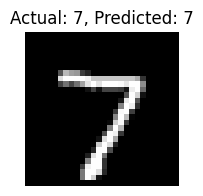

Sample 2 - Actual: 2, Predicted: 2


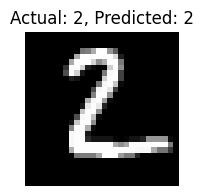

Sample 3 - Actual: 1, Predicted: 1


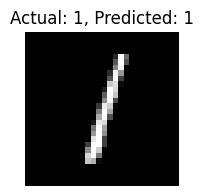

Sample 4 - Actual: 0, Predicted: 0


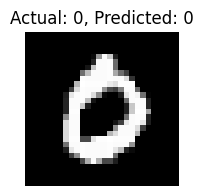

Sample 5 - Actual: 4, Predicted: 4


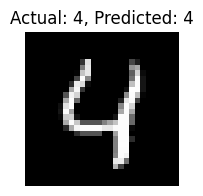

In [19]:
n_samples = 5

for i in range(n_samples):
    print(f"Sample {i+1} - Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")

    plt.figure(figsize=(2, 2))
    plt.imshow(sample_images[i].squeeze(), cmap="gray")
    plt.title(f"Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis("off")

    plt.show()

In [20]:
comparison_df = pd.DataFrame({"Sample": range(1, n_samples + 1),
                              "Actual": actual_labels[:n_samples],
                              "Predicted": predicted_labels[:n_samples]})

comparison_df.style.hide(axis="index")

Sample,Actual,Predicted
1,7,7
2,2,2
3,1,1
4,0,0
5,4,4
